In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.cuda import amp

In [2]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"dev: {dev}")





DATA_DIR = "dataset"
bs = 64
ncls = 2
epochs = 20
lr = 3e-5
wd = 1e-4
patience = 5
ckpt_path = "best_resnet50_f1.pth"
resume_weights = "resnet50_deepfake_finetuned.pth"  # keep or set None

dev: cuda


In [3]:
# aug
tr_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.2)),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
vt_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

tr_ds = datasets.ImageFolder(os.path.join(DATA_DIR,"train"), transform=tr_tf)
vl_ds = datasets.ImageFolder(os.path.join(DATA_DIR,"val"), transform=vt_tf)
te_ds = datasets.ImageFolder(os.path.join(DATA_DIR,"test"), transform=vt_tf)

tr_ld = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
vl_ld = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
te_ld = DataLoader(te_ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

# model
m = models.resnet50(pretrained=True)
for p in m.parameters(): p.requires_grad = False
# unfreeze layer4 and bn/last layers
for n, ch in m.named_children():
    if n == "layer4": 
        for p in ch.parameters(): p.requires_grad = True

in_f = m.fc.in_features
m.fc = nn.Sequential(
    nn.Linear(in_f, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(512, ncls)
)
m = m.to(dev)

if resume_weights and os.path.exists(resume_weights):
    sd = torch.load(resume_weights, map_location=dev)
    try:
        m.load_state_dict(sd)
        print("loaded resume weights")
    except Exception as e:
        print("loading weights failed:", e)

opt = optim.AdamW(filter(lambda p: p.requires_grad, m.parameters()), lr=lr, weight_decay=wd)
sched = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=3, T_mult=1)
scaler = amp.GradScaler()
crit = nn.CrossEntropyLoss()

# mixup helper (simple)
def mixup(x, y, a=0.4):
    if a <= 0: return x, y, 1.0, None
    lam = np.random.beta(a, a)
    idx = torch.randperm(x.size(0)).to(x.device)
    x2 = x[idx]
    y2 = y[idx]
    x = lam * x + (1-lam) * x2
    return x, y, lam, y2

def train_epoch(model, ld, opt, crit, scaler, use_mix=True):
    model.train()
    y_true = []
    y_pred = []
    tot_loss = 0.0
    pbar = tqdm(ld, desc="train", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(dev), yb.to(dev)
        if use_mix:
            xb, yb_a, lam, yb_b = mixup(xb, yb, a=0.3)
        opt.zero_grad()
        with amp.autocast(enabled=(dev.type=="cuda")):
            out = model(xb)
            if use_mix and lam < 1.0 and yb_b is not None:
                loss = lam * crit(out, yb_a) + (1-lam) * crit(out, yb_b.to(dev))
            else:
                loss = crit(out, yb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        tot_loss += loss.item() * xb.size(0)
        preds = out.argmax(1).detach().cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds)
        acc = 100.0 * (np.array(preds) == yb.cpu().numpy()).sum() / xb.size(0)
        pbar.set_postfix(loss=loss.item(), acc=f"{acc:.1f}%")
    avg_loss = tot_loss / len(ld.dataset)
    acc_epoch = accuracy_score(y_true, y_pred)
    f1_epoch = f1_score(y_true, y_pred, average='binary')
    return avg_loss, acc_epoch, f1_epoch

def eval_epoch(model, ld, crit):
    model.eval()
    y_true = []
    y_pred = []
    tot_loss = 0.0
    pbar = tqdm(ld, desc="eval", leave=False)
    with torch.no_grad():
        for xb, yb in pbar:
            xb, yb = xb.to(dev), yb.to(dev)
            out = model(xb)
            loss = crit(out, yb)
            tot_loss += loss.item() * xb.size(0)
            preds = out.argmax(1).detach().cpu().numpy()
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds)
            acc = 100.0 * (np.array(preds) == yb.cpu().numpy()).sum() / xb.size(0)
            pbar.set_postfix(loss=loss.item(), acc=f"{acc:.1f}%")
    avg_loss = tot_loss / len(ld.dataset)
    acc_epoch = accuracy_score(y_true, y_pred)
    f1_epoch = f1_score(y_true, y_pred, average='binary')
    return avg_loss, acc_epoch, f1_epoch, np.array(y_true), np.array(y_pred)

# training
t_losses, v_losses = [], []
t_accs, v_accs = [], []
t_f1s, v_f1s = [], []
best_f1 = -1.0
es_ctr = 0

for e in range(epochs):
    print(f"Epoch {e+1}/{epochs}")
    tr_loss, tr_acc, tr_f1 = train_epoch(m, tr_ld, opt, crit, scaler, use_mix=True)
    vl_loss, vl_acc, vl_f1, vl_y, vl_p = eval_epoch(m, vl_ld, crit)
    sched.step()
    t_losses.append(tr_loss); v_losses.append(vl_loss)
    t_accs.append(tr_acc); v_accs.append(vl_acc)
    t_f1s.append(tr_f1); v_f1s.append(vl_f1)

    print(f" epoch {e+1} train_acc {tr_acc*100:.2f}% train_f1 {tr_f1:.4f} | val_acc {vl_acc*100:.2f}% val_f1 {vl_f1:.4f}")

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        torch.save({
            "epoch": e+1,
            "model_state": m.state_dict(),
            "opt_state": opt.state_dict(),
            "best_f1": best_f1
        }, ckpt_path)
        print(f" saved best model (val_f1={best_f1:.4f})")
        es_ctr = 0
    else:
        es_ctr += 1
        print(f" no improvement for {es_ctr} epoch(s)")

    if es_ctr >= patience:
        print("early stopping")
        break

# final eval on test set
print("Running final evaluation on test set")
t_loss, t_acc, t_f1, t_y, t_p = eval_epoch(m, te_ld, crit)
print(f"TEST acc {t_acc*100:.2f}% f1 {t_f1:.4f}")

# load best for confusion matrix & final metrics (if exists)
if os.path.exists(ckpt_path):
    ck = torch.load(ckpt_path, map_location=dev)
    try:
        m.load_state_dict(ck["model_state"])
    except Exception:
        pass

_, te_acc, te_f1, y_true, y_pred = eval_epoch(m, te_ld, crit)
print(f"Best-model TEST acc {te_acc*100:.2f}% f1 {te_f1:.4f}")

C:\Users\samriddhi singh\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samriddhi singh\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Epoch 1/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 1 train_acc 71.10% train_f1 0.7130 | val_acc 88.65% val_f1 0.8967
 saved best model (val_f1=0.8967)
Epoch 2/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 2 train_acc 72.46% train_f1 0.7262 | val_acc 89.90% val_f1 0.9078
 saved best model (val_f1=0.9078)
Epoch 3/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 3 train_acc 73.28% train_f1 0.7340 | val_acc 92.36% val_f1 0.9283
 saved best model (val_f1=0.9283)
Epoch 4/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 4 train_acc 72.13% train_f1 0.7229 | val_acc 90.65% val_f1 0.9140
 no improvement for 1 epoch(s)
Epoch 5/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 5 train_acc 74.14% train_f1 0.7429 | val_acc 93.03% val_f1 0.9345
 saved best model (val_f1=0.9345)
Epoch 6/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 6 train_acc 73.41% train_f1 0.7354 | val_acc 94.17% val_f1 0.9446
 saved best model (val_f1=0.9446)
Epoch 7/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 7 train_acc 73.04% train_f1 0.7321 | val_acc 93.38% val_f1 0.9376
 no improvement for 1 epoch(s)
Epoch 8/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 8 train_acc 73.35% train_f1 0.7353 | val_acc 93.09% val_f1 0.9352
 no improvement for 2 epoch(s)
Epoch 9/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 9 train_acc 74.04% train_f1 0.7419 | val_acc 95.23% val_f1 0.9542
 saved best model (val_f1=0.9542)
Epoch 10/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 10 train_acc 73.79% train_f1 0.7396 | val_acc 94.88% val_f1 0.9509
 no improvement for 1 epoch(s)
Epoch 11/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 11 train_acc 73.46% train_f1 0.7361 | val_acc 95.17% val_f1 0.9537
 no improvement for 2 epoch(s)
Epoch 12/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 12 train_acc 73.74% train_f1 0.7388 | val_acc 95.40% val_f1 0.9558
 saved best model (val_f1=0.9558)
Epoch 13/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 13 train_acc 74.14% train_f1 0.7430 | val_acc 95.54% val_f1 0.9570
 saved best model (val_f1=0.9570)
Epoch 14/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 14 train_acc 74.84% train_f1 0.7501 | val_acc 95.22% val_f1 0.9542
 no improvement for 1 epoch(s)
Epoch 15/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 15 train_acc 73.83% train_f1 0.7395 | val_acc 95.76% val_f1 0.9591
 saved best model (val_f1=0.9591)
Epoch 16/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 16 train_acc 73.77% train_f1 0.7393 | val_acc 95.96% val_f1 0.9609
 saved best model (val_f1=0.9609)
Epoch 17/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
train:  83%|███████████████████████████████████████        | 1816/2188 [12:57<01:49,  3.40it/s, acc=100.0%, loss=0.128]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

 epoch 17 train_acc 74.70% train_f1 0.7484 | val_acc 96.06% val_f1 0.9619
 saved best model (val_f1=0.9619)
Epoch 18/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 18 train_acc 73.86% train_f1 0.7402 | val_acc 95.67% val_f1 0.9583
 no improvement for 1 epoch(s)
Epoch 19/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 19 train_acc 73.41% train_f1 0.7360 | val_acc 96.39% val_f1 0.9649
 saved best model (val_f1=0.9649)
Epoch 20/20


train:   0%|                                                                                  | 0/2188 [00:00<?, ?it/s]C:\Users\samriddhi singh\AppData\Local\Temp\ipykernel_16868\1212563961.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(dev.type=="cuda")):
                                                                                                                       

 epoch 20 train_acc 73.42% train_f1 0.7360 | val_acc 96.31% val_f1 0.9642
 no improvement for 1 epoch(s)
Running final evaluation on test set


TEST acc 84.96% f1 0.8390


Best-model TEST acc 85.40% f1 0.8434


saved train_val_curves.png
saved confusion_matrix.png


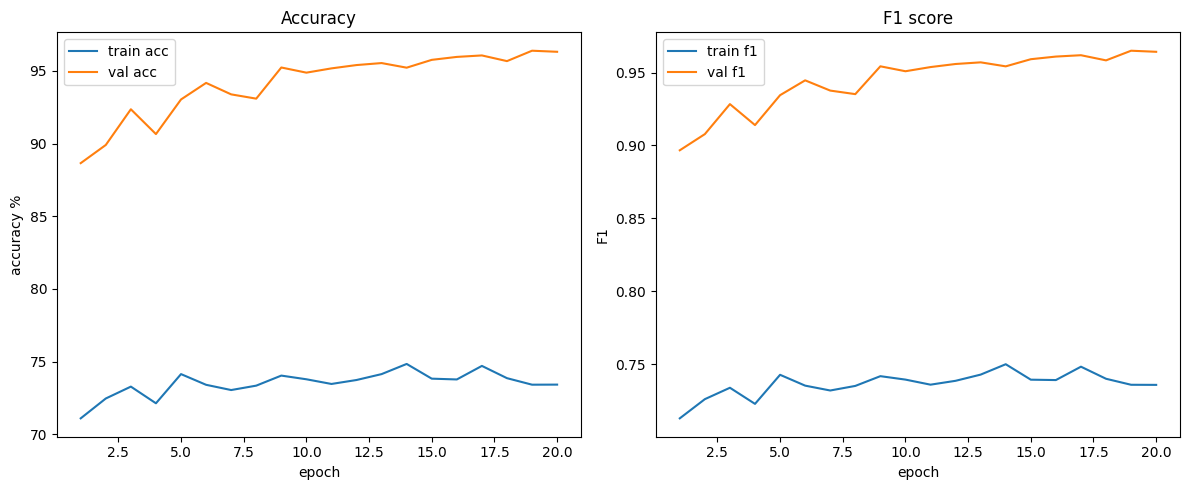

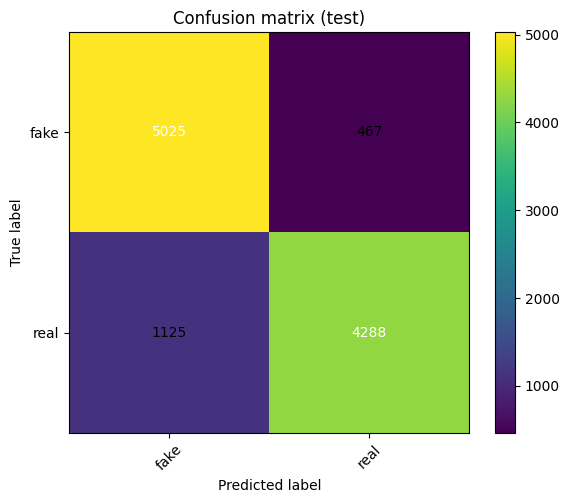

In [4]:
# plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(t_accs)+1), [a*100 for a in t_accs], label="train acc")
plt.plot(np.arange(1,len(v_accs)+1), [a*100 for a in v_accs], label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy %"); plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(1,len(t_f1s)+1), t_f1s, label="train f1")
plt.plot(np.arange(1,len(v_f1s)+1), v_f1s, label="val f1")
plt.xlabel("epoch"); plt.ylabel("F1"); plt.title("F1 score")
plt.legend()
plt.tight_layout()
plt.savefig("train_val_curves.png")
print("saved train_val_curves.png")

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = [c for c,_ in sorted(tr_ds.class_to_idx.items(), key=lambda x:x[1])]
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (test)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             verticalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("saved confusion_matrix.png")
